In [64]:
%matplotlib inline
import gensim
import caselawnet
import json
import nltk
import numpy as np 
import pandas as pd

In [65]:
fn = '/media/sf_VBox_Shared/CaseLaw/graphs/json_sigma/wgaans_community.json'


In [66]:
with open(fn) as f:
    network = json.load(f)

In [67]:
len(network['nodes'])

156

In [68]:
rootpath = '/media/sf_VBox_Shared/CaseLaw/OpenDataUitspraken/'

In [69]:
def get_text(ecli):
    query = '''
    prefix dcterm: <http://purl.org/dc/terms/>
    select ?o
    where {
        ?s dcterm:description ?o
    }
    '''
    el = caselawnet.enrich.retrieve_from_any(ecli, rootpath)
    if el is not None:
        g = caselawnet.parser.parse_xml_element(el, ecli)
        res = g.query(query)
        if len(res)>0:
            return list(res)[0][0].value
    return ""

In [71]:
for n in network['nodes']:
    n['text'] = get_text(n['ecli'])

Retrieved ECLI:NL:HR:2015:3019 from file system
Retrieved ECLI:NL:HR:2015:644 from file system
Retrieved ECLI:NL:HR:2014:3519 from file system
Retrieved ECLI:NL:HR:2014:943 from file system
Retrieved ECLI:NL:HR:2013:BZ1721 from file system
Retrieved ECLI:NL:HR:2013:BZ1717 from file system
Retrieved ECLI:NL:HR:2013:BZ1780 from file system
Retrieved ECLI:NL:HR:2012:BX7590 from file system
Retrieved ECLI:NL:HR:2012:BX0598 from file system
Retrieved ECLI:NL:HR:2012:BV1295 from file system
Retrieved ECLI:NL:HR:2011:BU7412 from file system
Retrieved ECLI:NL:HR:2011:BR5223 from file system
Retrieved ECLI:NL:HR:2011:BR5215 from file system
Retrieved ECLI:NL:HR:2011:BQ3514 from file system
Retrieved ECLI:NL:HR:2011:BQ3519 from file system
Retrieved ECLI:NL:HR:2011:BQ3517 from file system
Retrieved ECLI:NL:HR:2011:BP9991 from file system
Retrieved ECLI:NL:HR:2010:BO1799 from file system
Retrieved ECLI:NL:HR:2010:BN6236 from file system
Retrieved ECLI:NL:HR:2010:BN9977 from file system
Retrieved 

In [144]:
nodes_df = pd.DataFrame(network['nodes'])
nodes_df.community = nodes_df.community.astype(int)

In [145]:
stemmer = nltk.stem.snowball.DutchStemmer(ignore_stopwords=True)
def tokenize(text):
    tokenized = nltk.word_tokenize(text)
    return [stemmer.stem(w) for w in tokenized if w.isalnum()]

In [146]:
nodes_df['fulltext'] = [n['abstract'] + ' '+ n['text'] for n in network['nodes']]
nodes_df['tokenized'] = [tokenize(t) for t in nodes_df['fulltext']]

In [147]:
# Remove nodes without text
nodes_df = nodes_df[nodes_df['fulltext']!=' ']

In [148]:
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
# Some options:
ngram_range = (1, 2)
max_df = 0.8
min_df = 2
stop_words = get_stop_words('dutch')
vectorizer = CountVectorizer(ngram_range=ngram_range, 
                             max_df=max_df, 
                             min_df=min_df, 
                             tokenizer=tokenize, 
                             stop_words=stop_words)
wordcounts = vectorizer.fit_transform((n['fulltext'] for i, n in nodes_df.iterrows()))

In [149]:
from scipy import sparse
term_indices = sparse.lil_matrix(wordcounts.shape)
term_indices[wordcounts.nonzero()] = 1
term_indices = term_indices.tocsr()

In [150]:
a = 'abc'
a.find('h')

-1

In [151]:
[a for  a in vectorizer.get_feature_names() if a.find('art')>=0]

['1 art',
 '1 artikel',
 '1 daartoe',
 '1 maart',
 '10 maart',
 '11 maart',
 '12 maart',
 '13 maart',
 '14 maart',
 '15 maart',
 '16 maart',
 '17 maart',
 '18 maart',
 '19 maart',
 '1998 maart',
 '2 maart',
 '20 maart',
 '2001 partij',
 '21 maart',
 '22 maart',
 '23 maart',
 '24 maart',
 '25 maart',
 '27 maart',
 '28 maart',
 '3 maart',
 '30 maart',
 '31 maart',
 '4 maart',
 '5 bedrijfsart',
 '6 maart',
 '7 maart',
 '8 maart',
 '9 maart',
 'aangesprok partij',
 'aansluit art',
 'aansprak art',
 'aansprak partij',
 'aanvaard art',
 'aanzien art',
 'advocat partij',
 'af art',
 'afgewez daarteg',
 'afgewez daartoe',
 'all partij',
 'allen partij',
 'alsnog partij',
 'apart',
 'appeltermijn wederpartij',
 'arboned huisarts',
 'art 1',
 'art 10',
 'art 11',
 'art 12',
 'art 134',
 'art 150',
 'art 157',
 'art 1638x',
 'art 177',
 'art 19',
 'art 2',
 'art 24',
 'art 243',
 'art 25',
 'art 26',
 'art 3',
 'art 353',
 'art 4',
 'art 407',
 'art 450',
 'art 5',
 'art 55',
 'art 57b',
 'art 6'

In [163]:
def get_relevances(wordcounts, term_indices, cluster, clusters):
    cluster_ids = [i for i, c in enumerate(clusters) if c == cluster]
    wordcounts_cluster = wordcounts[cluster_ids, :]
    term_indices_cluster = term_indices[cluster_ids, :]
    cluster_total = wordcounts_cluster.sum(axis=0).tolist()[0]
    if wordcounts_cluster.sum() == 0:
        return None

    corpus_total = wordcounts.sum(axis=0).tolist()[0]
    cluster_counts = term_indices_cluster.sum(axis=0).tolist()[0]
    corpus_counts = term_indices.sum(axis=0).tolist()[0]
    dat = np.array([cluster_total, corpus_total,
                              cluster_counts, corpus_counts])
    relevances = pd.DataFrame(dat.transpose(), 
                              columns=['cl_tot', 'co_tot', 'cl_cnt', 'co_cnt'],
                              index=vectorizer.get_feature_names())
    relevances['rel_tot'] = relevances['cl_tot'] / relevances['co_tot']
    relevances['rel_cnt'] = relevances['cl_cnt'] / relevances['co_cnt']
    relevances['pw_cl'] = (wordcounts_cluster.sum(axis=0)/wordcounts_cluster.sum()).tolist()[0]
    relevances['pw_co'] = (wordcounts.sum(axis=0)/wordcounts.sum()).tolist()[0]
    
    relevances['prw_co'] = (wordcounts.sum(axis=0)/wordcounts.sum()).tolist()[0]
    
    relevances['pw_diff'] = relevances['pw_cl'] - relevances['pw_co']

    relevances['p_cl'] = term_indices_cluster.mean(axis=0).tolist()[0]
    relevances['p_co'] = term_indices.mean(axis=0).tolist()[0]
    relevances['p_diff'] = relevances['p_cl'] - relevances['p_co']
    relevances['p_logodds'] = np.log((relevances['p_cl'] / (1-relevances['p_cl'])) / (relevances['p_co'] / (1-relevances['p_co'])))
    relevances['pw_logodds'] = np.log((relevances['pw_cl'] / (1-relevances['pw_cl'])) / (relevances['pw_co'] / (1-relevances['pw_co'])))
    
    
    # Filter out rare words
    relevances = relevances[relevances['co_cnt']>1]
    relevances = relevances[relevances['cl_cnt']>1]
    return relevances

In [164]:
w = wordcounts
res = (w/w.sum(axis=0)).sum(axis=0) / w.sum()
res.sum()

0.10140712764520049

In [165]:
w/w.sum(axis=1)

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [166]:
nodes_df[nodes_df['ecli']=="ECLI:NL:HR:2010:BM9757"]

,abstract,articles,authorities,betweenness_centrality,closeness_centrality,community,count_annotation,count_version,creator,date,...,pagerank,rel_in_degree,subject,text,title,x,y,year,fulltext,tokenized


(8) 1.	Asbest (oranje netwerk, 14 uitspraken);

(4) 2.	Zorgplichtbegrip, inlening, eigen schuld en ‘grove schuld’ onder art. 7A:1638x BW (lichtblauwe cluster, 22 uitspraken), welk onderwerp verder zou kunnen worden uitgesplitst in eigen schuld en ‘grove schuld’ enerzijds en het zorgplichtbegrip en inlening anderzijds;

(0) 3.	Causaal verband (blauw-paarse cluster, 11 uitspraken);

(2) 4.	Verzekeringsplicht en woon-werkverkeer (blauwe cluster, 27 uitspraken);

(3?) 5.	Omkeringsregel algemeen (rode cluster, 6 uitspraken);

(?) 6.	Deskundigen, stelplicht en bewijslast (lichtblauwe cluster, 6 uitspraken).


In [170]:
from IPython.display import display

relevances_dict = {}
for cl in sorted(nodes_df.community.unique()):
    nodes_in_cluster = [i for i, node in enumerate(network['nodes']) if node['community']==str(cl)]
    nodes_with_text = nodes_df[nodes_df['community']==cl]
    print(cl, len(nodes_in_cluster), len(nodes_with_text))
    relevances = get_relevances(wordcounts, term_indices, cl, nodes_df.community)
    if relevances is not None:
        relevances = relevances.sort_values(['p_logodds', 'pw_logodds'], ascending=False)
        relevances_dict[cl] = relevances
        display(relevances.head(10))

0 18 16


/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log
/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
voort,44.0,173.0,16.0,80.0,0.254335,0.200000,0.001233,0.001113,0.001113,0.000120,1.0000,0.714286,0.285714,inf,0.102831
voldan,30.0,126.0,16.0,54.0,0.238095,0.296296,0.000841,0.000811,0.000811,0.000030,1.0000,0.482143,0.517857,inf,0.036758
vanaf,45.0,191.0,16.0,73.0,0.235602,0.219178,0.001262,0.001229,0.001229,0.000033,1.0000,0.651786,0.348214,inf,0.026234
zoal,54.0,235.0,16.0,84.0,0.229787,0.190476,0.001514,0.001512,0.001512,0.000002,1.0000,0.750000,0.250000,inf,0.001213
deskund,161.0,195.0,14.0,25.0,0.825641,0.560000,0.004513,0.001255,0.001255,0.003259,0.8750,0.223214,0.651786,3.192942,1.283485
waarschijn,30.0,43.0,13.0,20.0,0.697674,0.650000,0.000841,0.000277,0.000277,0.000564,0.8125,0.178571,0.633929,2.992393,1.112374
benoemd,30.0,36.0,12.0,16.0,0.833333,0.750000,0.000841,0.000232,0.000232,0.000609,0.7500,0.142857,0.607143,2.890372,1.290101
gezond gevar,22.0,23.0,9.0,10.0,0.956522,0.900000,0.000617,0.000148,0.000148,0.000469,0.5625,0.089286,0.473214,2.573702,1.427830
bevind deskund,10.0,10.0,7.0,7.0,1.000000,1.000000,0.000280,0.000064,0.000064,0.000216,0.4375,0.062500,0.375000,2.456736,1.472028
kort,38.0,129.0,15.0,63.0,0.294574,0.238095,0.001065,0.000830,0.000830,0.000235,0.9375,0.562500,0.375000,2.456736,0.249822


1 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
immuniteit,28.0,28.0,2.0,2.0,1.0,1.0,0.014127,0.000180,0.000180,0.013947,1.0,0.017857,0.982143,inf,4.376092
vervull tak,7.0,7.0,2.0,2.0,1.0,1.0,0.003532,0.000045,0.000045,0.003487,1.0,0.017857,0.982143,inf,4.365537
onmiddel verband,6.0,6.0,2.0,2.0,1.0,1.0,0.003027,0.000039,0.000039,0.002989,1.0,0.017857,0.982143,inf,4.365037
voorrecht,6.0,6.0,2.0,2.0,1.0,1.0,0.003027,0.000039,0.000039,0.002989,1.0,0.017857,0.982143,inf,4.365037
voorrecht immuniteit,6.0,6.0,2.0,2.0,1.0,1.0,0.003027,0.000039,0.000039,0.002989,1.0,0.017857,0.982143,inf,4.365037
houd vervull,5.0,5.0,2.0,2.0,1.0,1.0,0.002523,0.000032,0.000032,0.002491,1.0,0.017857,0.982143,inf,4.364538
immuniteit europes,5.0,5.0,2.0,2.0,1.0,1.0,0.002523,0.000032,0.000032,0.002491,1.0,0.017857,0.982143,inf,4.364538
immuniteit jurisdictie,5.0,5.0,2.0,2.0,1.0,1.0,0.002523,0.000032,0.000032,0.002491,1.0,0.017857,0.982143,inf,4.364538
jurisdictie,5.0,5.0,2.0,2.0,1.0,1.0,0.002523,0.000032,0.000032,0.002491,1.0,0.017857,0.982143,inf,4.364538
gedrag onmiddel,4.0,4.0,2.0,2.0,1.0,1.0,0.002018,0.000026,0.000026,0.001992,1.0,0.017857,0.982143,inf,4.364038


2 20 17


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
ongeval,149.0,313.0,17.0,50.0,0.476038,0.340000,0.006104,0.002014,0.002014,0.004090,1.000000,0.446429,0.553571,inf,1.112966
werkgever,233.0,530.0,17.0,67.0,0.439623,0.253731,0.009545,0.003410,0.003410,0.006135,1.000000,0.598214,0.401786,inf,1.035453
werknemer,251.0,621.0,17.0,69.0,0.404187,0.246377,0.010282,0.003996,0.003996,0.006287,1.000000,0.616071,0.383929,inf,0.951570
art bw,82.0,265.0,17.0,75.0,0.309434,0.226667,0.003359,0.001705,0.001705,0.001654,1.000000,0.669643,0.330357,inf,0.679764
geled,68.0,254.0,17.0,88.0,0.267717,0.193182,0.002786,0.001634,0.001634,0.001151,1.000000,0.785714,0.214286,inf,0.534444
uitgegan i,17.0,78.0,17.0,78.0,0.217949,0.217949,0.000696,0.000502,0.000502,0.000195,1.000000,0.696429,0.303571,inf,0.327816
cassatie volgend,17.0,80.0,17.0,80.0,0.212500,0.212500,0.000696,0.000515,0.000515,0.000182,1.000000,0.714286,0.285714,inf,0.302485
volgend uitgegan,17.0,83.0,17.0,83.0,0.204819,0.204819,0.000696,0.000534,0.000534,0.000162,1.000000,0.741071,0.258929,inf,0.265652
mak,27.0,205.0,17.0,89.0,0.131707,0.191011,0.001106,0.001319,0.001319,-0.000213,1.000000,0.794643,0.205357,inf,-0.176270
gevolg ongeval,38.0,59.0,15.0,28.0,0.644068,0.535714,0.001557,0.000380,0.000380,0.001177,0.882353,0.250000,0.632353,3.113515,1.412344


3 6 6


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
zak ontstan,12.0,12.0,6.0,6.0,1.0,1.0,0.001409,0.000077,0.000077,0.001331,1.0,0.053571,0.946429,39.60848,2.905184
beginsel gegev,11.0,11.0,6.0,6.0,1.0,1.0,0.001291,0.000071,0.000071,0.001220,1.0,0.053571,0.946429,39.60848,2.905073
risico vervolgen,9.0,9.0,6.0,6.0,1.0,1.0,0.001056,0.000058,0.000058,0.000999,1.0,0.053571,0.946429,39.60848,2.904851
schad gedrag,9.0,9.0,6.0,6.0,1.0,1.0,0.001056,0.000058,0.000058,0.000999,1.0,0.053571,0.946429,39.60848,2.904851
schad lev,9.0,9.0,6.0,6.0,1.0,1.0,0.001056,0.000058,0.000058,0.000999,1.0,0.053571,0.946429,39.60848,2.904851
vervolgen verwezenlijkt,9.0,9.0,6.0,6.0,1.0,1.0,0.001056,0.000058,0.000058,0.000999,1.0,0.053571,0.946429,39.60848,2.904851
risico ter,8.0,8.0,6.0,6.0,1.0,1.0,0.000939,0.000051,0.000051,0.000888,1.0,0.053571,0.946429,39.60848,2.904740
aangesprok stell,7.0,7.0,6.0,6.0,1.0,1.0,0.000822,0.000045,0.000045,0.000777,1.0,0.053571,0.946429,39.60848,2.904628
daarmee causal,7.0,7.0,6.0,6.0,1.0,1.0,0.000822,0.000045,0.000045,0.000777,1.0,0.053571,0.946429,39.60848,2.904628
gedrag ontstan,7.0,7.0,6.0,6.0,1.0,1.0,0.000822,0.000045,0.000045,0.000777,1.0,0.053571,0.946429,39.60848,2.904628


4 22 11


/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
overkom,14.0,88.0,10.0,41.0,0.159091,0.243902,0.001271,0.000566,0.000566,0.000705,0.909091,0.366071,0.543019,2.851693,0.809591
nj 1990,4.0,4.0,4.0,4.0,1.000000,1.000000,0.000363,0.000026,0.000026,0.000338,0.363636,0.035714,0.327922,2.736221,2.647502
juni 1990,4.0,4.0,3.0,3.0,1.000000,1.000000,0.000363,0.000026,0.000026,0.000338,0.272727,0.026786,0.245942,2.611906,2.647502
1990 716,3.0,3.0,3.0,3.0,1.000000,1.000000,0.000272,0.000019,0.000019,0.000253,0.272727,0.026786,0.245942,2.611906,2.647418
1997 werking,3.0,3.0,3.0,3.0,1.000000,1.000000,0.000272,0.000019,0.000019,0.000253,0.272727,0.026786,0.245942,2.611906,2.647418
716,3.0,3.0,3.0,3.0,1.000000,1.000000,0.000272,0.000019,0.000019,0.000253,0.272727,0.026786,0.245942,2.611906,2.647418
1990 nr,4.0,5.0,4.0,5.0,0.800000,0.800000,0.000363,0.000032,0.000032,0.000331,0.363636,0.044643,0.318994,2.503775,2.424352
werkgever rust,4.0,5.0,4.0,5.0,0.800000,0.800000,0.000363,0.000032,0.000032,0.000331,0.363636,0.044643,0.318994,2.503775,2.424352
excellent,48.0,48.0,2.0,2.0,1.000000,1.000000,0.004359,0.000309,0.000309,0.004050,0.181818,0.017857,0.163961,2.503256,2.651224
ebrex,12.0,12.0,2.0,2.0,1.000000,1.000000,0.001090,0.000077,0.000077,0.001013,0.181818,0.017857,0.163961,2.503256,2.648178


5 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
stelling feit,6.0,6.0,2.0,2.0,1.0,1.0,0.002108,0.000039,0.000039,0.002070,1.0,0.017857,0.982143,inf,4.002308
dient zodan,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
feit inroep,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
feit vind,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
inroep dient,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
overlegg processtuk,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
partij zulk,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
processtuk procedur,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
rechter wederpartij,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271
stuk stelling,3.0,3.0,2.0,2.0,1.0,1.0,0.001054,0.000019,0.000019,0.001035,1.0,0.017857,0.982143,inf,4.001271


6 9 7


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
dag,26.0,130.0,7.0,56.0,0.200000,0.125000,0.003054,0.000836,0.000836,0.002217,1.0,0.500000,0.500000,36.043653,1.297222
januari,32.0,230.0,7.0,72.0,0.139130,0.097222,0.003759,0.001480,0.001480,0.002279,1.0,0.642857,0.357143,35.455867,0.934380
betrok,65.0,642.0,7.0,72.0,0.101246,0.097222,0.007634,0.004131,0.004131,0.003504,1.0,0.642857,0.357143,35.455867,0.617762
december,27.0,226.0,7.0,75.0,0.119469,0.093333,0.003171,0.001454,0.001454,0.001717,1.0,0.669643,0.330357,35.337083,0.781462
lid,30.0,347.0,7.0,77.0,0.086455,0.090909,0.003524,0.002233,0.002233,0.001291,1.0,0.687500,0.312500,35.255196,0.457606
cassatiedagvaard arrest,7.0,80.0,7.0,79.0,0.087500,0.088608,0.000822,0.000515,0.000515,0.000307,1.0,0.705357,0.294643,35.170713,0.468630
gehecht maakt,7.0,85.0,7.0,84.0,0.082353,0.083333,0.000822,0.000547,0.000547,0.000275,1.0,0.750000,0.250000,34.945041,0.407973
maakt daarvan,7.0,85.0,7.0,84.0,0.082353,0.083333,0.000822,0.000547,0.000547,0.000275,1.0,0.750000,0.250000,34.945041,0.407973
behandel,23.0,220.0,7.0,86.0,0.104545,0.081395,0.002701,0.001415,0.001415,0.001286,1.0,0.767857,0.232143,34.847403,0.647594
veroordel,7.0,139.0,7.0,86.0,0.050360,0.081395,0.000822,0.000894,0.000894,-0.000072,1.0,0.767857,0.232143,34.847403,-0.084197


7 4 4


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
daaran gegev,21.0,21.0,4.0,4.0,1.000000,1.000000,0.003788,0.000135,0.000135,0.003653,1.0,0.035714,0.964286,inf,3.337094
eis daaran,18.0,18.0,4.0,4.0,1.000000,1.000000,0.003247,0.000116,0.000116,0.003131,1.0,0.035714,0.964286,inf,3.336570
mag stell,14.0,14.0,4.0,4.0,1.000000,1.000000,0.002525,0.000090,0.000090,0.002435,1.0,0.035714,0.964286,inf,3.335873
volded eis,13.0,13.0,4.0,4.0,1.000000,1.000000,0.002345,0.000084,0.000084,0.002261,1.0,0.035714,0.964286,inf,3.335698
omstand mag,9.0,10.0,4.0,5.0,0.900000,0.800000,0.001623,0.000064,0.000064,0.001559,1.0,0.044643,0.955357,inf,3.229634
gevar verwezenlijkt,6.0,7.0,4.0,5.0,0.857143,0.800000,0.001082,0.000045,0.000045,0.001037,1.0,0.044643,0.955357,inf,3.180321
volded,19.0,30.0,4.0,13.0,0.633333,0.307692,0.003427,0.000193,0.000193,0.003234,1.0,0.116071,0.883929,inf,2.879916
gegev omstand,22.0,55.0,4.0,25.0,0.400000,0.160000,0.003968,0.000354,0.000354,0.003614,1.0,0.223214,0.776786,inf,2.420766
gemeent,74.0,231.0,4.0,25.0,0.320346,0.160000,0.013348,0.001486,0.001486,0.011861,1.0,0.223214,0.776786,inf,2.207032
daaran,29.0,108.0,4.0,49.0,0.268519,0.081633,0.005231,0.000695,0.000695,0.004536,1.0,0.437500,0.562500,inf,2.023148


8 14 7


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
blootstell asbest,13.0,15.0,7.0,9.0,0.866667,0.777778,0.001082,0.000097,0.000097,0.000985,1.0,0.080357,0.919643,38.481158,2.417880
asbest,86.0,110.0,7.0,12.0,0.781818,0.583333,0.007158,0.000708,0.000708,0.006450,1.0,0.107143,0.892857,38.163917,2.320337
blootstell,50.0,185.0,7.0,21.0,0.270270,0.333333,0.004161,0.001190,0.001190,0.002971,1.0,0.187500,0.812500,37.509990,1.254641
ziekt,32.0,89.0,7.0,25.0,0.359551,0.280000,0.002663,0.000573,0.000573,0.002091,1.0,0.223214,0.776786,37.290686,1.539188
bekend,47.0,213.0,7.0,51.0,0.220657,0.137255,0.003912,0.001370,0.001370,0.002541,1.0,0.455357,0.544643,36.222702,1.051398
vastgesteld,11.0,121.0,7.0,57.0,0.090909,0.122807,0.000916,0.000779,0.000779,0.000137,1.0,0.508929,0.491071,36.007935,0.162236
verder noem,16.0,120.0,7.0,60.0,0.133333,0.116667,0.001332,0.000772,0.000772,0.000560,1.0,0.535714,0.464286,35.900553,0.545652
cassatie verder,10.0,111.0,7.0,60.0,0.090090,0.116667,0.000832,0.000714,0.000714,0.000118,1.0,0.535714,0.464286,35.900553,0.153168
weergegev,18.0,113.0,7.0,66.0,0.159292,0.106061,0.001498,0.000727,0.000727,0.000771,1.0,0.589286,0.410714,35.682640,0.723750
noem,18.0,137.0,7.0,66.0,0.131387,0.106061,0.001498,0.000881,0.000881,0.000617,1.0,0.589286,0.410714,35.682640,0.531003


9 2 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


10 3 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


11 3 3


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
aanbod,15.0,33.0,3.0,12.0,0.454545,0.250000,0.003279,0.000212,0.000212,0.003067,1.0,0.107143,0.892857,inf,2.740377
gepasseerd,6.0,16.0,3.0,10.0,0.375000,0.300000,0.001312,0.000103,0.000103,0.001209,1.0,0.089286,0.910714,inf,2.546143
lever,22.0,68.0,3.0,24.0,0.323529,0.125000,0.004810,0.000438,0.000438,0.004372,1.0,0.214286,0.785714,inf,2.401681
verzuim,5.0,16.0,3.0,10.0,0.312500,0.300000,0.001093,0.000103,0.000103,0.000990,1.0,0.089286,0.910714,inf,2.363602
verklar,39.0,155.0,3.0,54.0,0.251613,0.055556,0.008526,0.000997,0.000997,0.007529,1.0,0.482143,0.517857,inf,2.153464
nagelat,8.0,36.0,3.0,22.0,0.222222,0.136364,0.001749,0.000232,0.000232,0.001517,1.0,0.196429,0.803571,inf,2.023204
geleg,15.0,72.0,3.0,40.0,0.208333,0.075000,0.003279,0.000463,0.000463,0.002816,1.0,0.357143,0.642857,inf,1.959968
zoud,14.0,84.0,3.0,42.0,0.166667,0.071429,0.003061,0.000540,0.000540,0.002520,1.0,0.375000,0.625000,inf,1.736528
daarover,6.0,40.0,3.0,24.0,0.150000,0.125000,0.001312,0.000257,0.000257,0.001054,1.0,0.214286,0.785714,inf,1.629698
memorie,6.0,41.0,3.0,23.0,0.146341,0.130435,0.001312,0.000264,0.000264,0.001048,1.0,0.205357,0.794643,inf,1.604999


12 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
repatrier,8.0,8.0,2.0,2.0,1.0,1.0,0.003927,0.000051,0.000051,0.003876,1.0,0.017857,0.982143,inf,4.338556
kost repatrier,5.0,5.0,2.0,2.0,1.0,1.0,0.002455,0.000032,0.000032,0.002422,1.0,0.017857,0.982143,inf,4.337098
amro veroordeeld,4.0,4.0,2.0,2.0,1.0,1.0,0.001964,0.000026,0.000026,0.001938,1.0,0.017857,0.982143,inf,4.336612
amro bank,3.0,3.0,2.0,2.0,1.0,1.0,0.001473,0.000019,0.000019,0.001453,1.0,0.017857,0.982143,inf,4.336127
amro begrot,3.0,3.0,2.0,2.0,1.0,1.0,0.001473,0.000019,0.000019,0.001453,1.0,0.017857,0.982143,inf,4.336127
bank gevestigd,3.0,3.0,2.0,2.0,1.0,1.0,0.001473,0.000019,0.000019,0.001453,1.0,0.017857,0.982143,inf,4.336127
zijd abn,3.0,3.0,2.0,2.0,1.0,1.0,0.001473,0.000019,0.000019,0.001453,1.0,0.017857,0.982143,inf,4.336127
amsterdam 10,2.0,2.0,2.0,2.0,1.0,1.0,0.000982,0.000013,0.000013,0.000969,1.0,0.017857,0.982143,inf,4.335642
psychisch schad,2.0,2.0,2.0,2.0,1.0,1.0,0.000982,0.000013,0.000013,0.000969,1.0,0.017857,0.982143,inf,4.335642
rechtdoend abn,2.0,2.0,2.0,2.0,1.0,1.0,0.000982,0.000013,0.000013,0.000969,1.0,0.017857,0.982143,inf,4.335642


13 2 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


14 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
deutag,28.0,28.0,2.0,2.0,1.0,1.0,0.026217,0.000180,0.000180,0.026037,1.0,0.017857,0.982143,inf,5.006750
deutag nederland,7.0,7.0,2.0,2.0,1.0,1.0,0.006554,0.000045,0.000045,0.006509,1.0,0.017857,0.982143,inf,4.986894
eiser deutag,7.0,7.0,2.0,2.0,1.0,1.0,0.006554,0.000045,0.000045,0.006509,1.0,0.017857,0.982143,inf,4.986894
genaamd deutag,6.0,6.0,2.0,2.0,1.0,1.0,0.005618,0.000039,0.000039,0.005579,1.0,0.017857,0.982143,inf,4.985958
boortor,5.0,5.0,2.0,2.0,1.0,1.0,0.004682,0.000032,0.000032,0.004649,1.0,0.017857,0.982143,inf,4.985023
ass verweerster,3.0,3.0,2.0,2.0,1.0,1.0,0.002809,0.000019,0.000019,0.002790,1.0,0.017857,0.982143,inf,4.983156
daarvor genaamd,3.0,3.0,2.0,2.0,1.0,1.0,0.002809,0.000019,0.000019,0.002790,1.0,0.017857,0.982143,inf,4.983156
deutag friesland,3.0,3.0,2.0,2.0,1.0,1.0,0.002809,0.000019,0.000019,0.002790,1.0,0.017857,0.982143,inf,4.983156
drilling,3.0,3.0,2.0,2.0,1.0,1.0,0.002809,0.000019,0.000019,0.002790,1.0,0.017857,0.982143,inf,4.983156
drilling gevestigd,3.0,3.0,2.0,2.0,1.0,1.0,0.002809,0.000019,0.000019,0.002790,1.0,0.017857,0.982143,inf,4.983156


15 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
organisch oplosmiddel,3.0,3.0,2.0,2.0,1.000000,1.000000,0.001368,0.000019,0.000019,0.001349,1.0,0.017857,0.982143,inf,4.262230
2006 vonnis,2.0,2.0,2.0,2.0,1.000000,1.000000,0.000912,0.000013,0.000013,0.000899,1.0,0.017857,0.982143,inf,4.261780
brief 4,2.0,2.0,2.0,2.0,1.000000,1.000000,0.000912,0.000013,0.000013,0.000899,1.0,0.017857,0.982143,inf,4.261780
kantonrechter middelburg,3.0,4.0,2.0,3.0,0.750000,0.666667,0.001368,0.000026,0.000026,0.001342,1.0,0.026786,0.973214,inf,3.974541
mei 2008,3.0,4.0,2.0,3.0,0.750000,0.666667,0.001368,0.000026,0.000026,0.001342,1.0,0.026786,0.973214,inf,3.974541
26 april,2.0,3.0,2.0,3.0,0.666667,0.666667,0.000912,0.000019,0.000019,0.000893,1.0,0.026786,0.973214,inf,3.856308
4 maart,2.0,3.0,2.0,3.0,0.666667,0.666667,0.000912,0.000019,0.000019,0.000893,1.0,0.026786,0.973214,inf,3.856308
oplosmiddel,21.0,32.0,2.0,6.0,0.656250,0.333333,0.009576,0.000206,0.000206,0.009370,1.0,0.053571,0.946429,inf,3.849083
augustus 2006,3.0,6.0,2.0,5.0,0.500000,0.400000,0.001368,0.000039,0.000039,0.001329,1.0,0.044643,0.955357,inf,3.569063
middelburg,3.0,6.0,2.0,4.0,0.500000,0.500000,0.001368,0.000039,0.000039,0.001329,1.0,0.035714,0.964286,inf,3.569063


16 3 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
boetes,22.0,22.0,2.0,2.0,1.0,1.0,0.010353,0.000142,0.000142,0.010211,1.0,0.017857,0.982143,inf,4.302644
wahv,18.0,18.0,2.0,2.0,1.0,1.0,0.008471,0.000116,0.000116,0.008355,1.0,0.017857,0.982143,inf,4.300769
kentekenhouder,11.0,11.0,2.0,2.0,1.0,1.0,0.005176,0.000071,0.000071,0.005106,1.0,0.017857,0.982143,inf,4.297498
administratiev sancties,7.0,7.0,2.0,2.0,1.0,1.0,0.003294,0.000045,0.000045,0.003249,1.0,0.017857,0.982143,inf,4.295633
5 wahv,6.0,6.0,2.0,2.0,1.0,1.0,0.002824,0.000039,0.000039,0.002785,1.0,0.017857,0.982143,inf,4.295168
werknemer verhal,6.0,6.0,2.0,2.0,1.0,1.0,0.002824,0.000039,0.000039,0.002785,1.0,0.017857,0.982143,inf,4.295168
3 januari,4.0,4.0,2.0,2.0,1.0,1.0,0.001882,0.000026,0.000026,0.001857,1.0,0.017857,0.982143,inf,4.294237
opgelegd administratiev,4.0,4.0,2.0,2.0,1.0,1.0,0.001882,0.000026,0.000026,0.001857,1.0,0.017857,0.982143,inf,4.294237
snelheidsovertred,4.0,4.0,2.0,2.0,1.0,1.0,0.001882,0.000026,0.000026,0.001857,1.0,0.017857,0.982143,inf,4.294237
administratiev sanctie,3.0,3.0,2.0,2.0,1.0,1.0,0.001412,0.000019,0.000019,0.001392,1.0,0.017857,0.982143,inf,4.293772


17 5 4


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
dagvaard hoger,5.0,5.0,4.0,4.0,1.000000,1.000000,0.001430,0.000032,0.000032,0.001398,1.0,0.035714,0.964286,inf,3.795930
rechtsmiddel,11.0,24.0,4.0,7.0,0.458333,0.571429,0.003146,0.000154,0.000154,0.002992,1.0,0.062500,0.937500,inf,3.017369
eerst aanleg,9.0,39.0,4.0,22.0,0.230769,0.181818,0.002574,0.000251,0.000251,0.002323,1.0,0.196429,0.803571,inf,2.330521
dagvaard,16.0,73.0,4.0,37.0,0.219178,0.108108,0.004577,0.000470,0.000470,0.004107,1.0,0.330357,0.669643,inf,2.280778
aanleg,9.0,45.0,4.0,26.0,0.200000,0.153846,0.002574,0.000290,0.000290,0.002285,1.0,0.232143,0.767857,inf,2.187381
gedagvaard,17.0,106.0,4.0,84.0,0.160377,0.047619,0.004863,0.000682,0.000682,0.004181,1.0,0.750000,0.250000,inf,1.968498
geval onderhav,4.0,28.0,4.0,25.0,0.142857,0.160000,0.001144,0.000180,0.000180,0.000964,1.0,0.223214,0.776786,inf,1.849585
verwerpt beroep,5.0,59.0,4.0,56.0,0.084746,0.071429,0.001430,0.000380,0.000380,0.001051,1.0,0.500000,0.500000,inf,1.327483
verder noem,10.0,120.0,4.0,60.0,0.083333,0.066667,0.002860,0.000772,0.000772,0.002088,1.0,0.535714,0.464286,inf,1.311716
allen,7.0,86.0,4.0,50.0,0.081395,0.080000,0.002002,0.000553,0.000553,0.001449,1.0,0.446429,0.553571,inf,1.287545


18 8 6


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
kantonrechter vonnis,6.0,37.0,6.0,34.0,0.162162,0.176471,0.000843,0.000238,0.000238,0.000605,1.0,0.303571,0.696429,37.567149,1.265392
zorgplicht,35.0,207.0,6.0,41.0,0.169082,0.146341,0.004919,0.001332,0.001332,0.003587,1.0,0.366071,0.633929,37.285908,1.310173
overkom,12.0,88.0,6.0,41.0,0.136364,0.146341,0.001687,0.000566,0.000566,0.001120,1.0,0.366071,0.633929,37.285908,1.092637
stat vereffen,6.0,56.0,6.0,42.0,0.107143,0.142857,0.000843,0.000360,0.000360,0.000483,1.0,0.375000,0.625000,37.247626,0.850836
vereffen,6.0,56.0,6.0,42.0,0.107143,0.142857,0.000843,0.000360,0.000360,0.000483,1.0,0.375000,0.625000,37.247626,0.850836
vereffen volgen,6.0,56.0,6.0,42.0,0.107143,0.142857,0.000843,0.000360,0.000360,0.000483,1.0,0.375000,0.625000,37.247626,0.850836
bestred kantonrechter,6.0,43.0,6.0,43.0,0.139535,0.139535,0.000843,0.000277,0.000277,0.000567,1.0,0.383929,0.616071,37.209707,1.115071
volgen wet,6.0,59.0,6.0,43.0,0.101695,0.139535,0.000843,0.000380,0.000380,0.000464,1.0,0.383929,0.616071,37.209707,0.798631
rad verwerpt,6.0,48.0,6.0,48.0,0.125000,0.125000,0.000843,0.000309,0.000309,0.000534,1.0,0.428571,0.571429,37.024483,1.005038
ongeval,33.0,313.0,6.0,50.0,0.105431,0.120000,0.004638,0.002014,0.002014,0.002624,1.0,0.446429,0.553571,36.951912,0.836883


19 3 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


20 6 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
particulier,17.0,17.0,2.0,2.0,1.0,1.0,0.004652,0.000109,0.000109,0.004543,1.0,0.017857,0.982143,inf,3.754882
onderhav bepal,6.0,6.0,2.0,2.0,1.0,1.0,0.001642,0.000039,0.000039,0.001603,1.0,0.017857,0.982143,inf,3.751933
daarvan wet,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
formuler wet,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
natur person,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
recent datum,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
sted besliss,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
uitgemaakt,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
uitleg daarvan,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863
wet recent,2.0,2.0,2.0,2.0,1.0,1.0,0.000547,0.000013,0.000013,0.000534,1.0,0.017857,0.982143,inf,3.750863


21 3 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


22 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
vervalbed,15.0,15.0,2.0,2.0,1.0,1.0,0.004105,0.000097,0.000097,0.004009,1.0,0.017857,0.982143,inf,3.754345
beroep vervalbed,6.0,6.0,2.0,2.0,1.0,1.0,0.001642,0.000039,0.000039,0.001603,1.0,0.017857,0.982143,inf,3.751933
zelfstand onderzoek,4.0,4.0,2.0,2.0,1.0,1.0,0.001095,0.000026,0.000026,0.001069,1.0,0.017857,0.982143,inf,3.751398
dekkingsvrag,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130
lat gedan,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130
melding onderhav,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130
mogelijk onthoud,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130
omstand verzamel,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130
onthoud tijdig,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130
tijdig zelfstand,3.0,3.0,2.0,2.0,1.0,1.0,0.000821,0.000019,0.000019,0.000802,1.0,0.017857,0.982143,inf,3.751130


23 3 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
doorbrekingsgrond,6.0,6.0,2.0,2.0,1.0,1.0,0.003156,0.000039,0.000039,0.003118,1.0,0.017857,0.982143,inf,4.406893
eerlijk,5.0,5.0,2.0,2.0,1.0,1.0,0.002630,0.000032,0.000032,0.002598,1.0,0.017857,0.982143,inf,4.406372
eerlijk onpartijd,5.0,5.0,2.0,2.0,1.0,1.0,0.002630,0.000032,0.000032,0.002598,1.0,0.017857,0.982143,inf,4.406372
fundamentel,5.0,5.0,2.0,2.0,1.0,1.0,0.002630,0.000032,0.000032,0.002598,1.0,0.017857,0.982143,inf,4.406372
fundamentel rechtsbeginsel,5.0,5.0,2.0,2.0,1.0,1.0,0.002630,0.000032,0.000032,0.002598,1.0,0.017857,0.982143,inf,4.406372
onpartijd behandel,5.0,5.0,2.0,2.0,1.0,1.0,0.002630,0.000032,0.000032,0.002598,1.0,0.017857,0.982143,inf,4.406372
toepass gelat,4.0,4.0,2.0,2.0,1.0,1.0,0.002104,0.000026,0.000026,0.002078,1.0,0.017857,0.982143,inf,4.405851
buit toepassingsgebied,3.0,3.0,2.0,2.0,1.0,1.0,0.001578,0.000019,0.000019,0.001559,1.0,0.017857,0.982143,inf,4.405330
gelat wel,3.0,3.0,2.0,2.0,1.0,1.0,0.001578,0.000019,0.000019,0.001559,1.0,0.017857,0.982143,inf,4.405330
onrecht buit,3.0,3.0,2.0,2.0,1.0,1.0,0.001578,0.000019,0.000019,0.001559,1.0,0.017857,0.982143,inf,4.405330


24 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
dien stell,2.0,2.0,2.0,2.0,1.000000,1.000000,0.001299,0.000013,0.000013,0.001286,1.0,0.017857,0.982143,inf,4.615655
schadevergoed vordert,2.0,2.0,2.0,2.0,1.000000,1.000000,0.001299,0.000013,0.000013,0.001286,1.0,0.017857,0.982143,inf,4.615655
vordert dien,2.0,2.0,2.0,2.0,1.000000,1.000000,0.001299,0.000013,0.000013,0.001286,1.0,0.017857,0.982143,inf,4.615655
daarbij geldt,2.0,3.0,2.0,3.0,0.666667,0.666667,0.001299,0.000019,0.000019,0.001279,1.0,0.026786,0.973214,inf,4.210183
bw schadevergoed,2.0,4.0,2.0,4.0,0.500000,0.500000,0.001299,0.000026,0.000026,0.001273,1.0,0.035714,0.964286,inf,3.922495
eiser toegelat,2.0,4.0,2.0,4.0,0.500000,0.500000,0.001299,0.000026,0.000026,0.001273,1.0,0.035714,0.964286,inf,3.922495
werkzam werkgever,2.0,4.0,2.0,4.0,0.500000,0.500000,0.001299,0.000026,0.000026,0.001273,1.0,0.035714,0.964286,inf,3.922495
oktober 1997,5.0,11.0,2.0,6.0,0.454545,0.333333,0.003247,0.000071,0.000071,0.003176,1.0,0.053571,0.946429,inf,3.829092
14 april,4.0,9.0,2.0,6.0,0.444444,0.333333,0.002597,0.000058,0.000058,0.002539,1.0,0.053571,0.946429,inf,3.805981
eiser schad,3.0,7.0,2.0,4.0,0.428571,0.500000,0.001948,0.000045,0.000045,0.001903,1.0,0.035714,0.964286,inf,3.768975


25 2 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


26 2 1


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds


27 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
compensatie,9.0,9.0,2.0,2.0,1.0,1.0,0.008571,0.000058,0.000058,0.008514,1.0,0.017857,0.982143,inf,5.005911
intern compensatie,9.0,9.0,2.0,2.0,1.0,1.0,0.008571,0.000058,0.000058,0.008514,1.0,0.017857,0.982143,inf,5.005911
verklaart beroep,3.0,3.0,2.0,2.0,1.0,1.0,0.002857,0.000019,0.000019,0.002838,1.0,0.017857,0.982143,inf,5.000202
aanwez veroordel,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254
acht term,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254
arrest arrest,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254
belanghebb jar,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254
gegrond vernietigt,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254
hof verwijst,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254
inachtnem arrest,2.0,2.0,2.0,2.0,1.0,1.0,0.001905,0.000013,0.000013,0.001892,1.0,0.017857,0.982143,inf,4.999254


28 2 2


,cl_tot,co_tot,cl_cnt,co_cnt,rel_tot,rel_cnt,pw_cl,pw_co,prw_co,pw_diff,p_cl,p_co,p_diff,p_logodds,pw_logodds
bepal cao,3.0,3.0,2.0,2.0,1.0,1.0,0.001187,0.000019,0.000019,0.001168,1.0,0.017857,0.982143,inf,4.120286
elder cao,3.0,3.0,2.0,2.0,1.0,1.0,0.001187,0.000019,0.000019,0.001168,1.0,0.017857,0.982143,inf,4.120286
24 maand,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
aannem rechtsgevolg,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
behor schriftelijk,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
betekenis daarbij,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
cao gebruikt,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
cao toelicht,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
cao zover,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897
daarbij kenbar,2.0,2.0,2.0,2.0,1.0,1.0,0.000791,0.000013,0.000013,0.000779,1.0,0.017857,0.982143,inf,4.119897


In [169]:
import os 

output_path = '/media/sf_VBox_Shared/CaseLaw/graphs/clusters_text/wgaans/'
for i in relevances_dict:
    relevances_dict[i].to_csv(os.path.join(output_path, 'cl{}.csv'.format(i)))

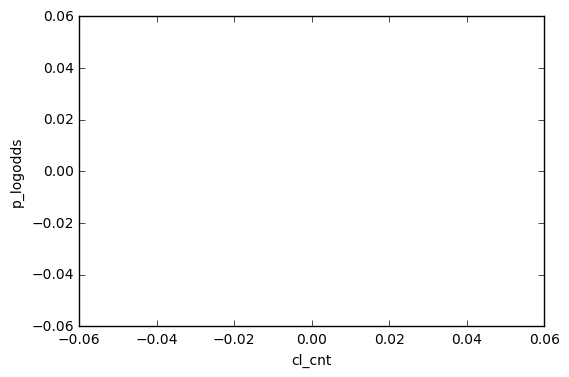

In [162]:
relevances_dict[4].plot('cl_cnt', 'p_logodds', kind='scatter')

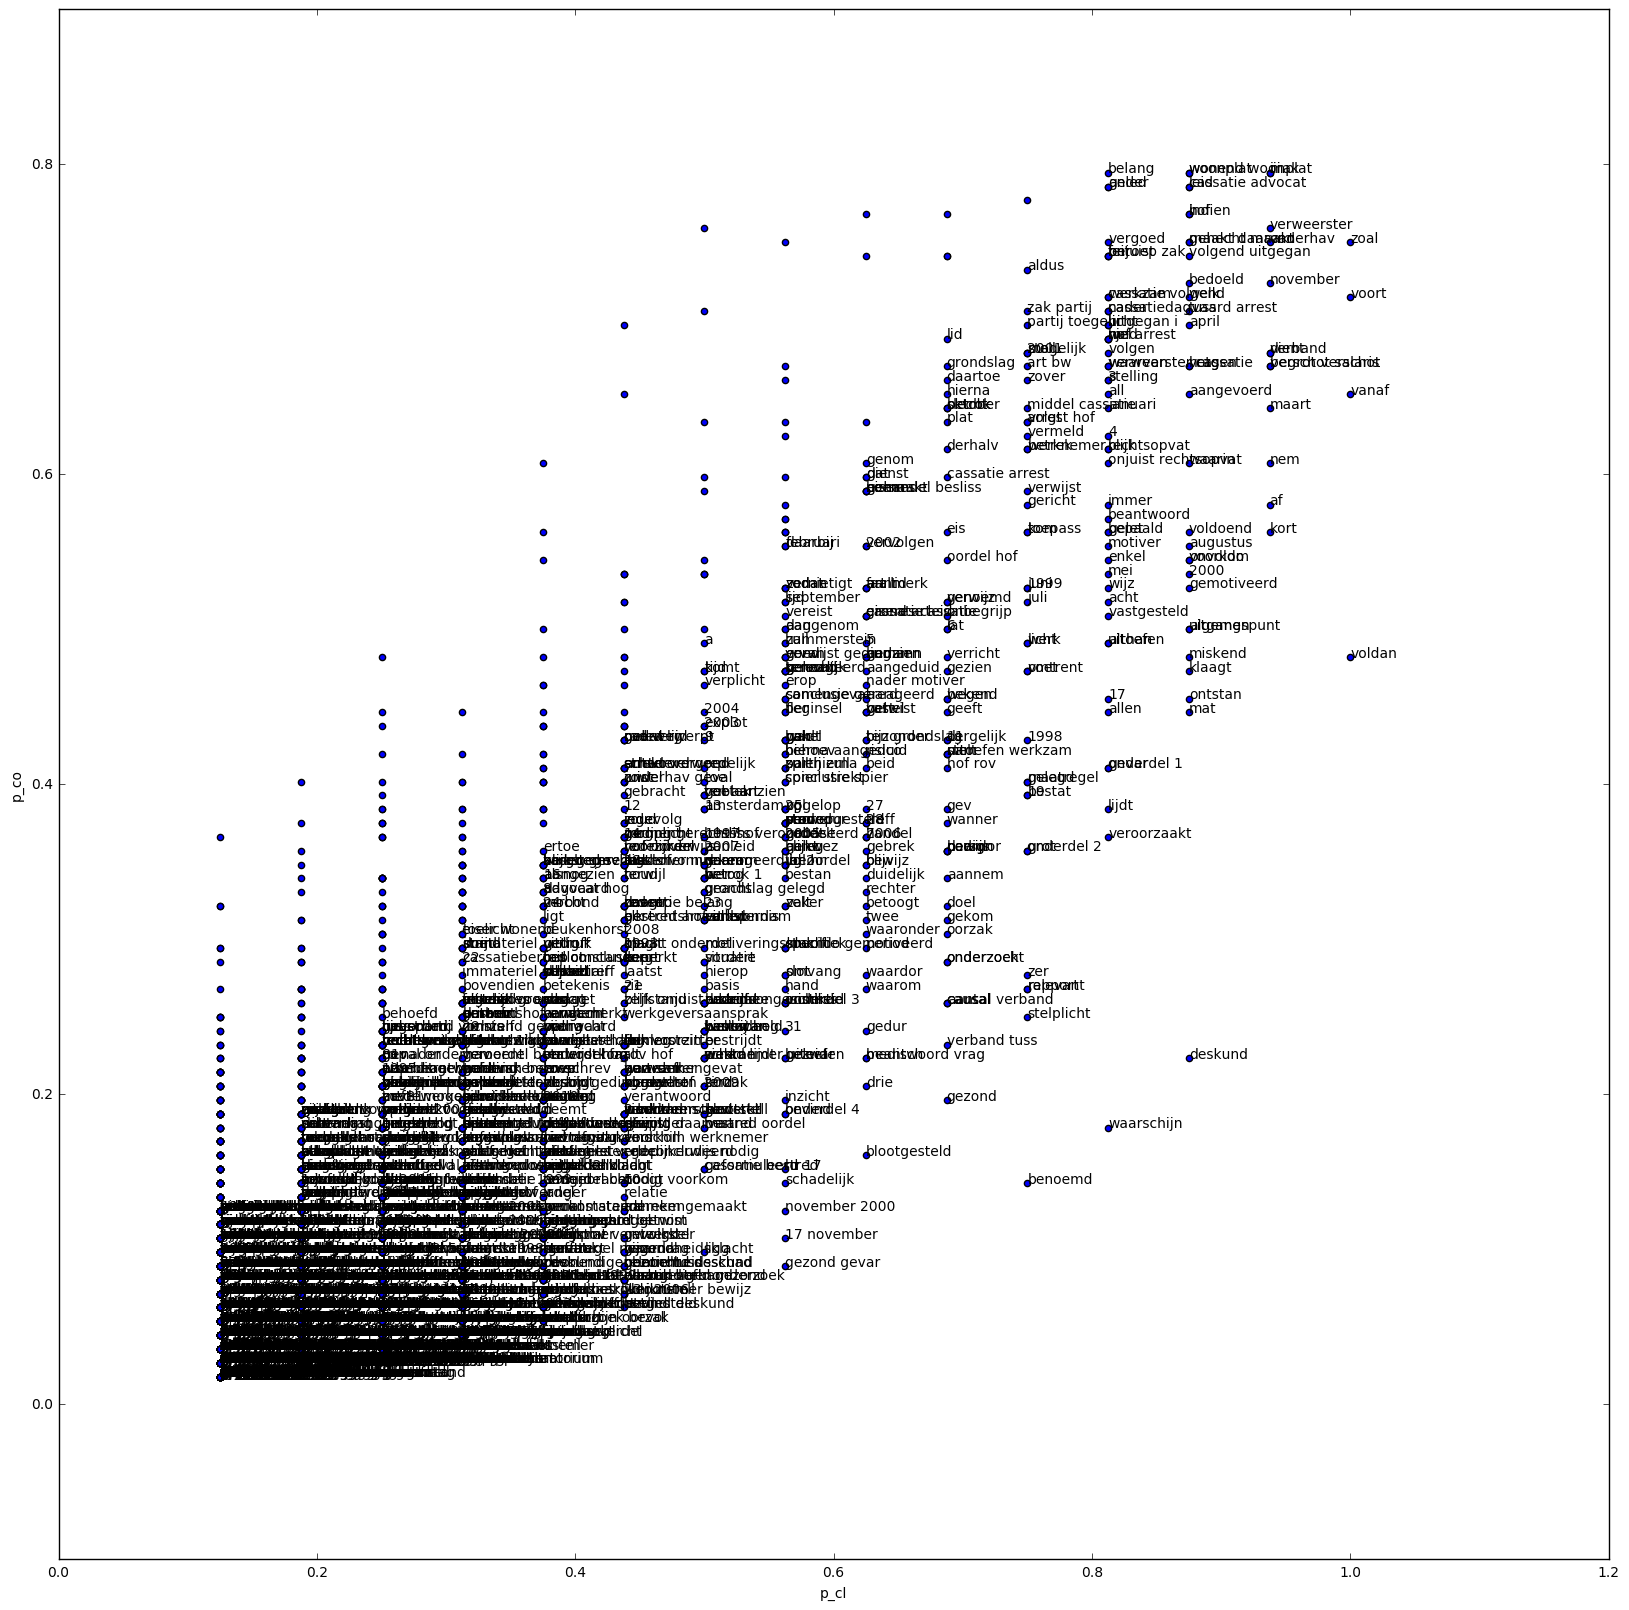

In [188]:
import matplotlib.pyplot as plt

relevances = relevances_dict[0]
relevances.plot('p_cl', 'p_co', kind='scatter', figsize=(20,20))
for (l, x, y) in relevances[['p_cl', 'p_co']].itertuples():
    if x > y:
        plt.annotate(l, xy=(x, y))
plt.show()

# Topic models

In [174]:

dictionary = gensim.corpora.Dictionary(nodes_df['tokenized'])

In [176]:
print(dictionary)

Dictionary(8360 unique tokens: ['ressorter', 'committee', 'herhaald', 'denkstoorniss', 'achter']...)


In [178]:
min_count = 2
no_above = 0.8
dictionary.filter_extremes(no_below=min_count, no_above=no_above)
dictionary.compactify() 
print(dictionary)

Dictionary(3857 unique tokens: ['verschil', 'verkocht', 'drog', 'herhaald', 'achter']...)


In [180]:
corpus = [dictionary.doc2bow(t) for t in nodes_df['tokenized']]

In [185]:
num_topics = len(relevances_dict.keys())
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, passes=10, id2word=dictionary)
corpus_lda = ldamodel[corpus]

In [186]:
ldamodel.print_topics()

[(10,
  '0.002*"hof" + 0.002*"verweerster" + 0.001*"verweerder" + 0.001*"eiser" + 0.001*"werkzam" + 0.001*"werkgever" + 0.001*"zou" + 0.001*"ongeval" + 0.001*"gemeent" + 0.001*"lid"'),
 (5,
  '0.016*"eiseres" + 0.016*"eiser" + 0.012*"incidentel" + 0.012*"procedur" + 0.008*"kantonrechter" + 0.008*"betrok" + 0.008*"hof" + 0.008*"cassatieberoep" + 0.008*"opzet" + 0.007*"roekelos"'),
 (1,
  '0.025*"gemeent" + 0.017*"richtlijn" + 0.011*"ondernem" + 0.010*"bank" + 0.009*"hof" + 0.009*"zou" + 0.008*"zin" + 0.008*"lid" + 0.008*"arbeidsovereenkomst" + 0.008*"recht"'),
 (9,
  '0.006*"reik" + 0.006*"amstelven" + 0.006*"atypisch" + 0.006*"concretiser" + 0.006*"blok" + 0.006*"vaststond" + 0.004*"hof" + 0.003*"verweerster" + 0.002*"werkzam" + 0.002*"rsi"'),
 (7,
  '0.002*"eiser" + 0.002*"hof" + 0.001*"verweerster" + 0.001*"werkzam" + 0.001*"vergoed" + 0.001*"deskund" + 0.001*"procedur" + 0.001*"maar" + 0.001*"oktober" + 0.001*"zoal"'),
 (18,
  '0.018*"verzekerar" + 0.017*"eiseres" + 0.016*"hof" + 0.